# 1.1.	Preliminary assessment of Plane of Array irradiance measurements against theoretical sun path
NOTE: python 3.7 installed locally, remote version ?
**BEWARE** all precise locations to be masked even in folder path
[Python releases status](https://www.python.org/downloads/)

**Content**
- [Trentino Alto Adige](#eurac)

In [1]:
#retrieving stored variables
%store -r
#remove unwanted cache
%store -d spam ax
#automatically reload
%load_ext autoreload
# autoreload 0 if deactivated 2 if all modules but excluded -
%autoreload 1

In [2]:
#interrupt when needed
%aimport data_operations, decorators, pvlib

In [3]:
from textwrap import wrap
import pandas as pd
import numpy as np
from pvlib import spa as spnrel
from clear_sky import datetime_to_utc
import datetime

from typing import List, Dict

from os import getcwd, listdir
from os.path import join, dirname

import data_operations as dtop

import matplotlib.pyplot as plt

#for commonly used decorators
import decorators
#for nb specific decorators
import functools


from clear_sky import SolarLibrary

import matplotlib as mpl
from mpl_toolkits.axes_grid1 import host_subplot

from empiricaldist import Pmf, Cdf
#https://nbviewer.jupyter.org/github/AllenDowney/empiricaldist/blob/master/empiricaldist/dist_demo.ipynb
#https://campus.datacamp.com/courses/exploratory-data-analysis-in-python/distributions?ex=2

In [4]:
#re-executing only final functions and visualisation outputs using cached variables
execute= True #default: False

In [5]:
WRAP_WIDTH = 80
pd.set_option('display.max_columns', 10)
mpl.style.use(['seaborn-paper', 'thesis'])

#Module position is retrieved through [digimap](#https://digimap.edina.ac.uk/)
LATITUDE = 52.7616
#negative longitude based on solar convention
LONGITUDE =  - (1.2406)
ALTITUDE = 79
PRESSURE = 101325.
TEMPERATURE = 12
DELTA_T = 67.0
ATMOS_REFRACT = 0.5667
TRANSMITTANCE = 0.5

SURFACE_ZENITH = 34
SURFACE_AZIMUTH = 180

NUMTHREADS = 4

ASSETS_FOLDER = join(dirname(getcwd()) + r"/assets/")

delta_t = DELTA_T
observer_longitude = LONGITUDE
observer_longitude = LONGITUDE
observer_latitude = LATITUDE
observer_elevation = ALTITUDE
local_pressure =PRESSURE
local_temp = TEMPERATURE
atmos_refract = ATMOS_REFRACT
numthreads = NUMTHREADS

title_template = f'Hourly disconnection analysis of %s from %s to %s'

RM_FOLDER=  r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/BAYWARE/doc_shared/_ST/Fiumicino/"
RM_PYR_C1="Pyranometer Cab 1_fm.csv"
RM_PYR_C4="Pyranometer Cab 4_fm.csv"

In [6]:
#decorators
describe_with_tukey_fence = decorators.add_tukey_fences(pd.DataFrame.describe)
plt_savefig = decorators.change_savefig(plt.savefig)
#removing white box appearing at the end
plt.close()
pd.read_csv = decorators.timer(pd.read_csv)
#common functions used during the NB

def add_hour(datetimes):
    dt_to_hour = lambda x: x.hour + x.minute / 60 + x.second / 3600
    if isinstance(datetimes, pd.DataFrame):
        for c in datetimes.columns.to_list():
            t = datetimes[c].dtype
            if str(t) == 'datetime64[ns]':
                datetimes[c + '_h'] = datetimes[c].apply(dt_to_hour)
    elif isinstance(datetimes, pd.Series):
        datetimes =datetimes.apply(dt_to_hour)
    elif isinstance(datetimes, pd.DatetimeIndex):
        datetimes = dt_to_hour(datetimes)
    return datetimes

#function to extract hidden location info
def get_com_sl(func):
    #plt.show()
    @functools.wraps(func)
    def send_com_info(folder:str, *args, **kwargs):
        com_info = pd.read_csv(filepath_or_buffer=folder+'pv_com_info.csv', delimiter=",",header=0, index_col=0)
        for i in com_info.index:
            kwargs[i] = com_info.loc[i,"value"]
        value = func(*args, **kwargs)
        return value
    return send_com_info

SolarLibrary_com = get_com_sl(SolarLibrary)

@decorators.timer
def clean_df(df: pd.DataFrame, dt_format='%d/%m/%Y %H:%M'):
    df.rename(dict(zip(df.columns.to_list(), ["dt", "gpoa"])), inplace=True, axis=1)
    #extracting raw duplicates before any transformation
    dup_condition = df.duplicated(subset='dt', keep=False) == True
    df_duplicates = df.loc[dup_condition,:].sort_values(by='dt')
    # kept last based on post-analysis
    # DEV NOTE 8/4/21 Is a decorator to remove duplicates with na values even before dropna useful ?
    df.drop_duplicates(subset='dt', keep='last', inplace=True)
    #converting to nan instead of raising error
    df.dt = pd.to_datetime(arg=df.dt, format=dt_format, errors="ignore")
    #tz not considered for faster processing
    df.index = pd.DatetimeIndex(df.dt.values)
    return df.sort_index(), df_duplicates

@decorators.timer
def get_sunpath_tz(dti:pd.DatetimeIndex, sl:SolarLibrary, freq:str="min") -> pd.DataFrame:
    #AmbiguousTimeError: 2017-10-29 02:00:00
    #replace with nan since solar path only for visualisation
    dti_tz = dti.tz_localize(tz=sl.timezone, ambiguous='NaT', nonexistent='NaT')
    dti_utc = dti_tz.tz_convert('utc')
    #DEV NOTE 17/4/21 removed since double convert extend index !!
    #dti_none = dti_utc.tz_convert(None)
    cs = sl.getsuninout(utc= dti_utc, freq= freq)
    dt_columns = ['sun_on', 'sun_off', 'sun_max']
    for c in dt_columns:
        dti_sl_utc = pd.DatetimeIndex(cs.loc[:,c].values, tz='utc', ambiguous='NaT')
        dti_sl_tz = dti_sl_utc.tz_convert(tz=sl.timezone)
        #exctracting hour since converting to None will go back to utc
        cs[c+'_h'] = add_hour(dti_sl_tz)
    return cs

@decorators.timer
#elements not in the first series
def series_differences(s1: pd.Series, s2: pd.Series):
    #initialise empty Series rather than None (not valid index)
    dff = pd.Series(dtype=float, name=s2.name)
    if s2 is not None and len(s2)>0:
        if s1 is None or len(s1) == 0:
            dff = s2
        elif len(s1) > 0:
            s2_name = s2.name
            s1.name = 's1'
            s2.name = 's2'
            df = pd.concat([s2, s1], axis=1, join='outer')
            df.dropna(subset=['s2'], inplace=True)
            df["dff"] = df.apply(lambda x: x['s2'] if x['s2'] != x['s1'] else None, axis=1)
            df.dropna(subset=['dff'], inplace=True)
            if len(df) > 0:
                dff = df.dff
                dff.name = s2_name
    return dff

#from typing import List, Dict
#DEV NOTE 10/4/21 clunky function could be optimised with list, tuple and dict

@decorators.timer
def plot_completeness(df1_dly:pd.DataFrame, title:str, before_hours_sum: bool=False,
                       suffix1:str="", df2_dly:pd.DataFrame = None, suffix2:str="", days_limit=24,
                       annotate1:bool=True, annotate2:bool=False, annotatation_min_hours=48,
                       annotatation_min_hours2=48,
                       ydistmin=100, ydistmin2=100, annotate_verticalshift=5, annotate_horizontalshift=5):
    df2notindf1 = []
    bbox_boxstyle="round"
    bbox_fc='w'
    annotate_size= 'xx-small'
    #right to show line after
    annotate_horizontalalignment = 'right'
    annotate_color = 'k'
    annotate_xytext = (0,-1)
    annotate_textcoords = 'offset points'
    annotate_verticalalignment = 'center'
    #shift currently used only for total
    #DEV NOTES 18/4/21 redundant with single plot, to be merged
    #external to retrive hours_limit_1
    dly_dsc_1 = describe_with_tukey_fence(df1_dly, percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
    hours_limit_1 = dly_dsc_1.loc['fence_tukey_max','before_first_hours']
    #external to retrieve separetely for first and last
    #@decorators.timer
    def get_measurement_series(dly:pd.DataFrame, hours_limit=hours_limit_1, days_limit:int=days_limit):
        dscbig = dly[(dly["after_last_hours"] >= days_limit)] #.rename({'last_hour':''}, inplace=True)
        rcvbig = dly[(dly["before_first_hours"] >= days_limit)] #.rename({'last_first':''}, inplace=True)
        dscsmall = dly[(dly["after_last_hours"] > hours_limit) &  (dly["after_last_hours"] < days_limit)]
        rcvsmall = dly[(dly["before_first_hours"] > hours_limit) & (dly["before_first_hours"] < days_limit)] #.rename({'last_first':''}, inplace=True)
        first_only = dly[(~dly.index.isin(rcvbig.index))&(~dly.index.isin(rcvsmall.index))]
        last_only =  dly[(~dly.index.isin(dscbig.index))&(~dly.index.isin(dscsmall.index))]
        return dscbig, rcvbig, dscsmall, rcvsmall, first_only, last_only




    graphs_dfs = []
    graphs_labels = []
    graphs_marker = []
    legend = []
    dscbig, rcvbig, dscsmall, rcvsmall, first_only, last_only = get_measurement_series(df1_dly, hours_limit_1)
    dfs_1 = [rcvsmall.first_hour, dscsmall.last_hour, rcvbig.first_hour, dscbig.last_hour,
                                    first_only.first_hour, last_only.last_hour]
    labels_1 = ['overnight disconnection end', 'overnight disconnection start',
    'day-long disconnection end', 'day-long disconnection start', 'first measurement', 'last measurement']
    markers_1 = ['g4', 'r2', 'g>', 'r^', 'g,', 'r,']

    if 'max_hour' in df1_dly.columns.to_list():
        graphs_dfs.append(df1_dly.max_hour)
        graphs_labels.append('max measurement value'+suffix1)
        graphs_marker.append('y*')

    for i in range(len(dfs_1)):
        if len(dfs_1[i]) > 0:
            graphs_dfs.append(dfs_1[i])
            graphs_labels.append(labels_1[i]+suffix1)
            graphs_marker.append(markers_1[i])

    if  df2_dly is not None:
        dly_dsc_2 = describe_with_tukey_fence(df2_dly, percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
        hours_limit_2 = dly_dsc_2.loc['fence_tukey_max','before_first_hours']
        dscbig2, rcvbig2, dscsmall2, rcvsmall2, first_only2, last_only2 = get_measurement_series(df2_dly, hours_limit_2)

        dfs_2 = [rcvsmall2.first_hour, dscsmall2.last_hour, rcvbig2.first_hour, dscbig2.last_hour,
                                    first_only2.first_hour, last_only2.last_hour]

        markers_2 = ['b4', 'm2', 'b>', 'm^', 'b,', 'm,']


        for i in range(len(dfs_2)):
            #for 2o visualising only series differences between the two dataframes
            dff = series_differences(dfs_1[i], dfs_2[i])
            df2notindf1.append(dff)
            if len(dff) > 0:
                graphs_dfs.append(dff)
                graphs_labels.append(labels_1[i]+suffix2)
                graphs_marker.append(markers_2[i])

    if ('sun_on_h' in df1_dly.columns.to_list()) & ('sun_off_h' in df1_dly.columns.to_list()):
        [graphs_dfs.append(i) for i in [df1_dly.sun_on_h, df1_dly.sun_off_h]]
        [graphs_labels.append(i) for i in ['sun on'+suffix1, 'sun off'+suffix1]]
        [graphs_marker.append(i) for i in ['k,', 'k,']]


    host = host_subplot(111)
    par = host.twinx()

    for i in range(0, len(graphs_dfs)):
        if len(graphs_dfs[i])>0:
            #alpha=0.5 for transparency
            host.plot(graphs_dfs[i].index, graphs_dfs[i], graphs_marker[i])
            legend.append(graphs_labels[i])

    if  before_hours_sum == True:
        _ = lambda x: x-hours_limit_1 if x>hours_limit_1 else 0
        df1_dly["before_first_hours_cml"] = pd.Series([df1_dly.loc[:x,'before_first_hours'].apply(_).sum() for x in df1_dly.index],
                      index=df1_dly.index)
        label = "cumulative disconnection hours"
        par.set_ylabel(label)
        p2, = par.plot(df1_dly.index, df1_dly.before_first_hours_cml, ":")
        #21/4/21
        legend.append(label+suffix1)

        #DEV NOTE 24/04/21 fixed ydistmin but dynamic from figsize & y could be used ?
        def hrz_alg(r, annotate_horizontalalignment, before_first_hours_cml,ydist=ydistmin):
            if r["before_first_hours_cml"] - before_first_hours_cml < ydist:
                if annotate_horizontalalignment =='right':
                    annotate_horizontalalignment = 'left'
                    horizontalshift = 1
                elif annotate_horizontalalignment =='left':
                    annotate_horizontalalignment = 'right'
                    horizontalshift = -1
            else:
                annotate_horizontalalignment = 'right'
                horizontalshift = 0
            return annotate_horizontalalignment, horizontalshift*annotate_horizontalshift

        bbox = dict(boxstyle=bbox_boxstyle, fc=bbox_fc, edgecolor="blue")
        ann_str = f'tot{str(suffix1)}: {max(df1_dly.before_first_hours_cml)/24:.0f}d, {max(df1_dly.before_first_hours_cml)/dtop.tdhour(max(df1_dly.index)-min(df1_dly.index))*100:.2f}%'
        par.annotate(ann_str,
        (max(df1_dly.index), max(df1_dly.before_first_hours_cml)),
        bbox=bbox, size=annotate_size, horizontalalignment="right",
        xytext=(annotate_xytext[0], annotate_xytext[1]+annotate_verticalshift), textcoords=annotate_textcoords,
        verticalalignment=annotate_verticalalignment)

        before_first_hours_cml = 0

        if annotate1:
            long_dsc1 = df1_dly.loc[df1_dly.before_first_hours > annotatation_min_hours,
                            ["before_first_hours","first_datetime","before_first_hours_cml"]]
            for i, r in long_dsc1.iterrows():


                bfhl = f'{r["before_first_hours"]/24:.0f}d' if r["before_first_hours"]>24 else f'{r["before_first_hours"]:.0f}h'
                ann_str = bfhl+f', {r["first_datetime"].strftime("%m/%d %H:%M")}'
                annotate_horizontalalignment, hs = hrz_alg(r, annotate_horizontalalignment, before_first_hours_cml, ydistmin)
                par.annotate(ann_str,
                (i, r["before_first_hours_cml"]),
                bbox=bbox, size=annotate_size, horizontalalignment=annotate_horizontalalignment,
                xytext=(annotate_xytext[0]+hs, annotate_xytext[1]), textcoords=annotate_textcoords,
                verticalalignment=annotate_verticalalignment)

                before_first_hours_cml = r["before_first_hours_cml"]

        if df2_dly is not None:
            df2_dly["before_first_hours_cml"] = pd.Series([df2_dly.loc[:x,'before_first_hours'].apply(_).sum() for x in df2_dly.index],
                          index=df2_dly.index)
            label = "cumulative disconnection hours"
            par.set_ylabel(label)
            p2, = par.plot(df2_dly.index, df2_dly.before_first_hours_cml,":")
            legend.append(label+suffix2)

            #22/4/22
            bbox = dict(boxstyle=bbox_boxstyle, fc=bbox_fc, edgecolor='orange')
            ann_str = f'tot{str(suffix2)}: {max(df2_dly.before_first_hours_cml)/24:.0f}d, {max(df2_dly.before_first_hours_cml)/dtop.tdhour(max(df2_dly.index)-min(df2_dly.index))*100:.2f}%'
            par.annotate(ann_str,
            (max(df2_dly.index), max(df2_dly.before_first_hours_cml)),
            bbox=bbox, size=annotate_size, horizontalalignment="left",
            xytext=(annotate_xytext[0]+annotate_horizontalshift, annotate_xytext[1]+annotate_verticalshift), textcoords=annotate_textcoords,
            verticalalignment=annotate_verticalalignment)

            before_first_hours_cml = 0
            if annotate2:
                #filtering minimum only for main not for differences
                if annotate1:
                    bfh_dff = series_differences(df1_dly.before_first_hours, df2_dly.before_first_hours)
                    day_dsc2 = df2_dly.loc[bfh_dff.index,
                                ["before_first_hours","first_datetime","before_first_hours_cml"]]
                elif annotate1 == False:
                    day_dsc2 = df2_dly[["before_first_hours","first_datetime","before_first_hours_cml"]]
                day_dsc2 = day_dsc2.loc[day_dsc2.before_first_hours > annotatation_min_hours2,
                                ["before_first_hours","first_datetime","before_first_hours_cml"]]
                for i, r in day_dsc2.iterrows():
                    bfhl = f'{r["before_first_hours"]/24:.0f}d' if r["before_first_hours"]>24 else f'{r["before_first_hours"]:.0f}h'
                    ann_str = bfhl+f', {r["first_datetime"].strftime("%m/%d %H:%M")}'
                    annotate_horizontalalignment, hs  = hrz_alg(r, annotate_horizontalalignment, before_first_hours_cml,ydistmin2)

                    par.annotate(ann_str,
                    (i, r["before_first_hours_cml"]),
                    bbox=bbox, size=annotate_size, horizontalalignment=annotate_horizontalalignment,
                    xytext=(annotate_xytext[0]+hs, annotate_xytext[1]), textcoords=annotate_textcoords,
                    verticalalignment=annotate_verticalalignment)

                    before_first_hours_cml = r["before_first_hours_cml"]

    plt.legend(labels=legend)
    plt.title('\n'.join(wrap(title,WRAP_WIDTH)))
    host.set_ylabel("hour")
    host.set_xlabel('date')
    #plt.show() not required
    plt_savefig = decorators.change_savefig(plt.savefig)
    plt_savefig()

    return df2notindf1

TBC visualisation could be done, risk overlaps

## Data completeness PV system

In [7]:
if execute:
    PV_FOLDER=r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/_Research_Master/_Data Sources/Skytron_Data_TEST/"
    PV_FILE=r"devicedata_0921.csv"

#Exploratory analysis of file structure
#https://stackoverflow.com/questions/10933838/how-to-read-a-csv-file-in-reverse-order-in-python
import csv
with open(PV_FOLDER+PV_FILE, 'r') as textfile:
    rows = list(csv.reader(textfile))
c = 0
print("First 10 rows")
for r in rows:
    print(', '.join(r))
    c += 1
    if c == 20:
        break
print("\n Last 5 rows")
c = 0
for r in reversed(rows):
    print(', '.join(r))
    c += 1
    if c == 5:
        break
print(len(rows))

In [8]:
if execute:
    gpoa_com = pd.read_csv(filepath_or_buffer=PV_FOLDER+PV_FILE, delimiter=";",skip_blank_lines=True,header=11,nrows=597792)
    print(gpoa_com.columns)
    gpoa_com.date = pd.to_datetime(gpoa_com.date, format='%Y-%m-%d %H:%M:%S')
    gpoa_com.index = pd.DatetimeIndex(gpoa_com.date, ambiguous='NaT', name="datetime")
    print(min(gpoa_com.index), max(gpoa_com.index))
    gpoa_com.rename({'p150506_c0401005002_0501001a':'global_swdn'}, axis=1, inplace=True)

Started 'read_csv' at 2021-05-16 18:21:10.623595
Finished 'read_csv' in 0:00:00.568036 secs
Index(['date', 'p150506_c0401005002_0501001a', 'p150506_c0401005002_0501011a'], dtype='object')
2015-06-03 16:29:00 2016-08-11 09:21:00


In [9]:
if execute:
    gpoa_com_info = pd.read_csv(filepath_or_buffer=PV_FOLDER+'pv_com_info.csv', delimiter=",",header=0, index_col=0)
    surface_zenith_com = gpoa_com_info.loc["surface_tilt","value"]#%%
    altitude_com = gpoa_com_info.loc["altitude","value"]#
    latitude_com = gpoa_com_info.loc["latitude","value"]#
    longitude_com = gpoa_com_info.loc["longitude","value"]#
    sl_com = SolarLibrary(latitude=latitude_com, longitude=longitude_com, altitude=altitude_com,
                     temperature=TEMPERATURE, delta_t=DELTA_T, pressure=PRESSURE,
                      surface_zenith=surface_zenith_com, surface_azimuth=SURFACE_AZIMUTH,
                      atmos_refract=ATMOS_REFRACT, transmittance=TRANSMITTANCE)

Started 'read_csv' at 2021-05-16 18:21:13.262598
Finished 'read_csv' in 0:00:00.005028 secs


In [10]:
if execute:
    m = gpoa_com.global_swdn
    dly_c = dtop.datacompleteness(m, time_resolution_s_max=3600)
    cs_dly_c = sl_com.getsuninout(utc= m.index, freq= "min")
    cs_dly_c = add_hour(cs_dly_c)
    dly_c = dly_c.merge(cs_dly_c.loc[:, ['sun_on_h','sun_off_h']], how='inner', left_index=True, right_index=True)
    %store dly_c

Started 'datacompleteness' at 2021-05-16 18:21:13.295598
Finished 'datacompleteness' in 0:00:01.979998 secs
Started 'getsuninout' at 2021-05-16 18:21:15.275596
Finished 'getsuninout' in 0:00:14.417272 secs
Stored 'dly_c' (DataFrame)


C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance\source\data_operations.py:238: FutureWarning: The 'keep_tz' keyword in DatetimeIndex.to_series is deprecated and will be removed in a future version.  You can stop passing 'keep_tz' to silence this warning.
  utc_all = _.to_series(index=None, name=datetime_column, keep_tz=True)[:-1]


Started 'plot_completeness' at 2021-05-16 18:21:29.738837
Started 'describe' at 2021-05-16 18:21:29.738837
Finished 'describe' in 0:00:00.032960 secs
Hourly disconnection analysis of a pyranometer located in a solar farm in Glamorgan from 2015-06-03 to 2016-08-11.jpg saved at C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance/outputs/figures/
Finished 'plot_completeness' in 0:00:01.272177 secs


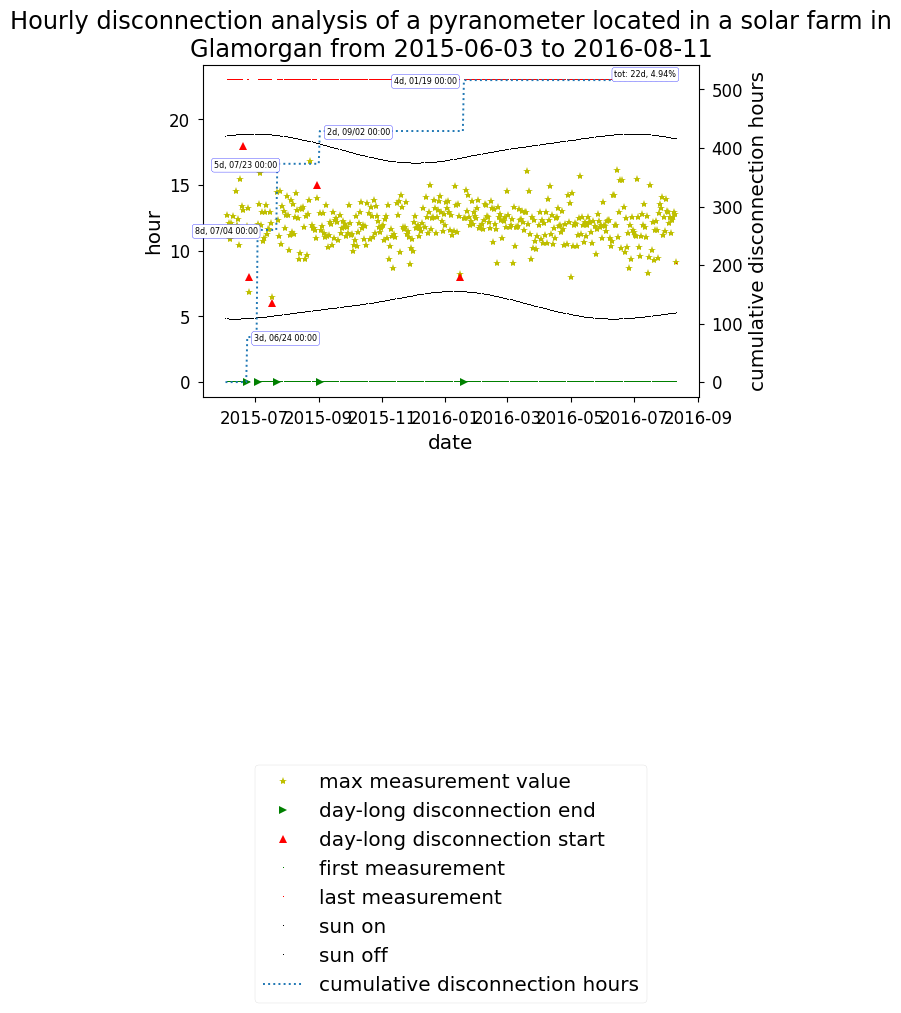

[]

In [11]:
title_c = title_template % ("a pyranometer located in a solar farm in Glamorgan", min(dly_c.index), max(dly_c.index))
plot_completeness(dly_c, title_c, before_hours_sum=True)

## Data completeness CREST

In [12]:
if execute:
    ISC_IRRADIANCE_FILES_FOLDER = join(dirname(getcwd())+r"/assets/isc_irradiance_files/")
    gpoa = pd.read_csv(filepath_or_buffer=join(ISC_IRRADIANCE_FILES_FOLDER,'chpoa_y15-20.csv'))
    gpoa.columns

Started 'read_csv' at 2021-05-16 18:21:31.054016
Finished 'read_csv' in 0:00:00.073998 secs


In [13]:
if execute:
    gpoa.date_trunc = pd.to_datetime(gpoa.date_trunc, format='%d/%m/%Y %H:%M:%S')
    gpoa.index = pd.DatetimeIndex(gpoa.date_trunc, ambiguous='NaT', name="datetime")
    min(gpoa.index), max(gpoa.index)

### Adding sun path
Just for nice visualisation, not strictly necessary
#surface zenith & azimuth not used at this point but later

In [14]:
sl_r = SolarLibrary(latitude=LATITUDE, longitude=LONGITUDE, altitude=ALTITUDE,
                 temperature=TEMPERATURE, delta_t=DELTA_T, pressure=PRESSURE,
                  surface_zenith=SURFACE_ZENITH, surface_azimuth=SURFACE_AZIMUTH,
                  atmos_refract=ATMOS_REFRACT, transmittance=TRANSMITTANCE)

In [15]:
if execute:
    m = gpoa.g_cmp11_ppuk
    dly_r = dtop.datacompleteness(m, time_resolution_s_max=3600)
    cs_dly_r = sl_r.getsuninout(utc= m.index, freq= "min")
    cs_dly_r = add_hour(cs_dly_r)
    dly_r = dly_r.merge(cs_dly_r.loc[:, ['sun_on_h','sun_off_h']], how='inner', left_index=True, right_index=True)
    %store dly_r

Started 'datacompleteness' at 2021-05-16 18:21:31.531045
Finished 'datacompleteness' in 0:00:03.728002 secs
Started 'getsuninout' at 2021-05-16 18:21:35.259047
Finished 'getsuninout' in 0:01:02.742604 secs
Stored 'dly_r' (DataFrame)


C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance\source\data_operations.py:238: FutureWarning: The 'keep_tz' keyword in DatetimeIndex.to_series is deprecated and will be removed in a future version.  You can stop passing 'keep_tz' to silence this warning.
  utc_all = _.to_series(index=None, name=datetime_column, keep_tz=True)[:-1]


Started 'plot_completeness' at 2021-05-16 18:22:38.094656
Started 'describe' at 2021-05-16 18:22:38.094656
Finished 'describe' in 0:00:00.028996 secs
Hourly disconnection analysis of a research pyranometer located at Loughborough University from 2015-01-01 to 2020-12-31.jpg saved at C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance/outputs/figures/
Finished 'plot_completeness' in 0:00:03.306999 secs


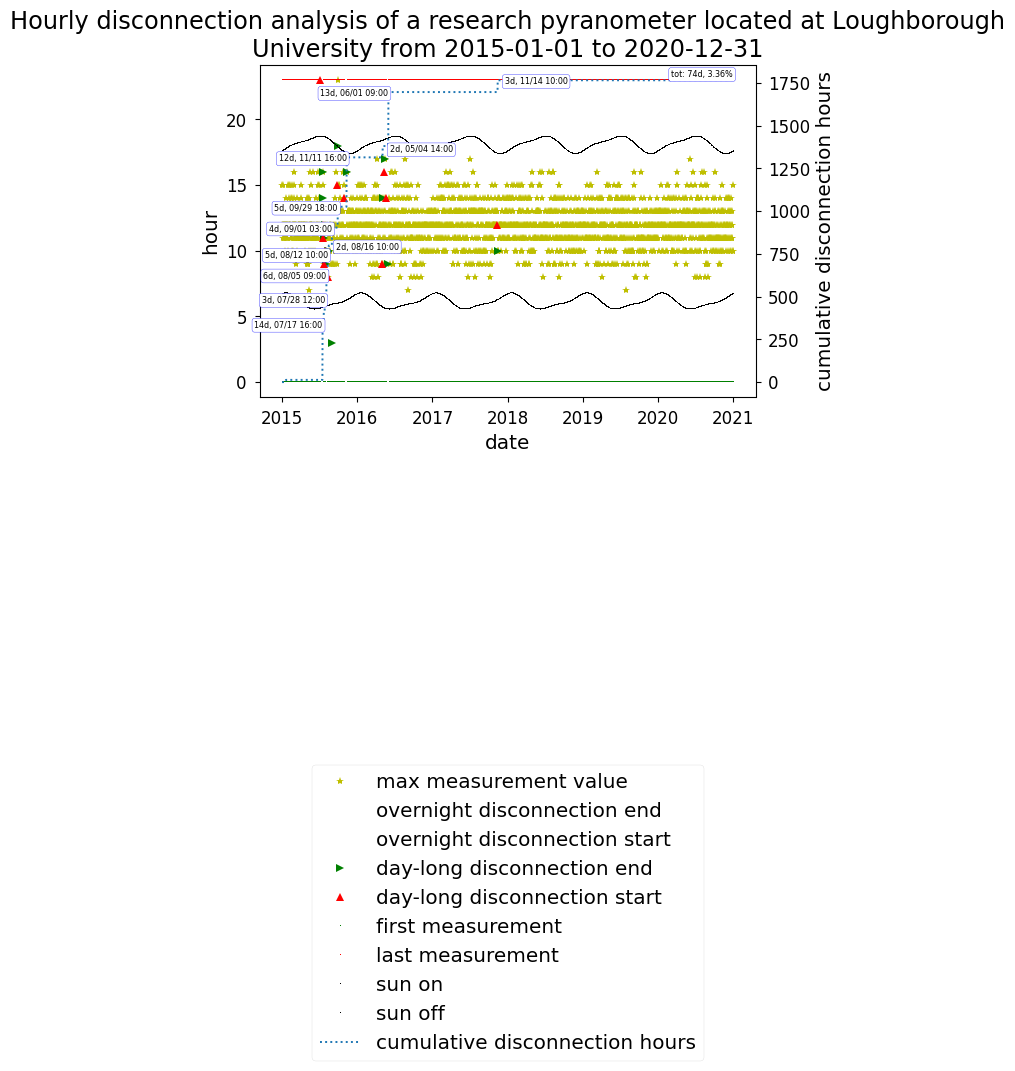

[]

In [16]:
title_r = title_template % ("a research pyranometer located at Loughborough University", min(dly_r.index), max(dly_r.index))
plot_completeness(dly_r, title_r, before_hours_sum=True)

In [17]:
# filtering for the same period for a better comparison
if execute:
    gpoa_s = gpoa[(gpoa.index >= min(gpoa_com.index)) & (gpoa.index <= max(gpoa_com.index))]
    m = gpoa_s.g_cmp11_ppuk
    dly_r_s = dtop.datacompleteness(m, time_resolution_s_max=3600)
    dly_r_s = dly_r_s.merge(cs_dly_r.loc[:, ['sun_on_h','sun_off_h']], how='inner', left_index=True, right_index=True)
    %store dly_r_s

Started 'datacompleteness' at 2021-05-16 18:22:43.064686
Finished 'datacompleteness' in 0:00:00.939974 secs
Stored 'dly_r_s' (DataFrame)


C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance\source\data_operations.py:238: FutureWarning: The 'keep_tz' keyword in DatetimeIndex.to_series is deprecated and will be removed in a future version.  You can stop passing 'keep_tz' to silence this warning.
  utc_all = _.to_series(index=None, name=datetime_column, keep_tz=True)[:-1]


## Calculating percentage of disconnection for the selected period

# Solar farms in Lazio

In [18]:
#first cleaning the dataset
if execute:
    df_rm1 = pd.read_csv(filepath_or_buffer=join(RM_FOLDER,RM_PYR_C1))
    df_rm1c, df_duplicates1 = clean_df(df_rm1)

Started 'read_csv' at 2021-05-16 18:22:44.040661
Finished 'read_csv' in 0:00:00.227996 secs
Started 'clean_df' at 2021-05-16 18:22:44.269671
Finished 'clean_df' in 0:00:01.024985 secs


In [19]:
sl_rm = SolarLibrary_com(folder=RM_FOLDER)
sl_rm.timezone = 'Europe/Rome'

Started 'read_csv' at 2021-05-16 18:22:45.316662
Finished 'read_csv' in 0:00:00.002999 secs


#fast compare with sun_rise_set_transit to verify if tz or utc and eventually shift

In [20]:
df_rm1c.index = df_rm1c.index.shift(periods=-1,freq=datetime.timedelta(seconds=int(60*60)))

In [21]:
tzs = df_rm1c.index.tz
tzs

In [22]:
df_rm1v = df_rm1c.dropna(subset=["gpoa"])
df_rm1v = df_rm1v[df_rm1v.gpoa > 20]
df_rm1v.dt = df_rm1v.index
df_rm1v['date'] = df_rm1v.index.date
df_rm1v['hour'] = df_rm1v.index.hour
dates = np.unique(df_rm1v.date)
#Daylight hours IEC 61724-1 2017 P
df_mm = df_rm1v.groupby(["date"]).agg({'gpoa':['max', 'idxmax']})
df_mm.columns = df_mm.columns.droplevel(0)
df_mm = pd.concat([df_mm.rename(columns={'max':'gmax', 'idxmax':'dtmax'}),
df_rm1v[df_rm1v.hour <=12].groupby(["date"]).agg({'dt':'first', 'gpoa':'first'}).rename(
    columns={'gpoa':'gfirst', 'dt':'dtfirst'}),
df_rm1v[df_rm1v.hour >=12].groupby(["date"]).agg({'dt':'last', 'gpoa':'last'}).rename(
    columns={'gpoa':'glast', 'dt':'dtlast'})], join='inner', axis=1)
df_mm.head()

,gmax,dtmax,dtfirst,gfirst,dtlast,glast
date,,,,,,
2016-11-09,910.0,2016-11-09 12:00:00,2016-11-09 07:05:00,42.0,2016-11-09 16:10:00,26.0
2016-11-10,874.0,2016-11-10 12:25:00,2016-11-10 07:20:00,22.0,2016-11-10 16:35:00,22.0
2016-11-11,866.0,2016-11-11 13:30:00,2016-11-11 07:20:00,52.0,2016-11-11 16:30:00,48.0
2016-11-12,862.0,2016-11-12 10:55:00,2016-11-12 07:10:00,26.0,2016-11-12 16:40:00,36.0
2016-11-13,794.0,2016-11-13 12:35:00,2016-11-13 07:10:00,36.0,2016-11-13 15:50:00,24.0


In [23]:
#versione requiring array and not datetimeindex
#https://pvlib-python.readthedocs.io/en/stable/_modules/pvlib/spa.html
import pvlib
dti = pd.DatetimeIndex(df_mm.index, tz=sl_rm.timezone, ambiguous='NaT')
srst = pvlib.solarposition.sun_rise_set_transit_spa(dti, sl_rm.latitude, sl_rm.longitude, how='numpy', delta_t=67.0, numthreads=4)
srst.index = srst.index.date
srst

,sunrise,sunset,transit
2016-11-09,2016-11-09 06:53:16.370965760+01:00,2016-11-09 16:55:33.662146816+01:00,2016-11-09 11:54:39.284754688+01:00
2016-11-10,2016-11-10 06:54:30.082078720+01:00,2016-11-10 16:54:32.147255296+01:00,2016-11-10 11:54:45.140632576+01:00
2016-11-11,2016-11-11 06:55:43.709738496+01:00,2016-11-11 16:53:32.390592768+01:00,2016-11-11 11:54:51.828773376+01:00
2016-11-12,2016-11-12 06:56:57.222740480+01:00,2016-11-12 16:52:34.430926336+01:00,2016-11-12 11:54:59.353043968+01:00
2016-11-13,2016-11-13 06:58:10.589783808+01:00,2016-11-13 16:51:38.306634496+01:00,2016-11-13 11:55:07.717057280+01:00
...,...,...,...
2019-03-15,2019-03-15 06:23:27.784808960+01:00,2019-03-15 18:16:51.773409024+01:00,2019-03-15 12:19:48.785765888+01:00
2019-03-16,2019-03-16 06:21:46.103023616+01:00,2019-03-16 18:17:59.766371328+01:00,2019-03-16 12:19:31.852552960+01:00
2019-03-17,2019-03-17 06:20:04.167721472+01:00,2019-03-17 18:19:07.544065536+01:00,2019-03-17 12:19:14.687570176+01:00
2019-03-18,2019-03-18 06:18:22.012542464+01:00,2019-03-18 18:20:15.119915008+01:00,2019-03-18 12:18:57.314189312+01:00


In [24]:
df_mm_tz = df_mm.copy(deep=True)
tze = sl_rm.timezone
for c in df_mm.columns.to_list():
    if "dt" in c:
        try:
            dti = pd.DatetimeIndex(df_mm_tz[c], tz=tzs)
            dti = dti.tz_convert(tz=tze) if tze!=tzs else dti
            df_mm_tz[c] = dti
        except TypeError:
            print(c)

dtmax
dtfirst
dtlast


In [25]:
df_mm_tz = df_mm_tz.merge(srst, left_index=True, right_index=True, how='inner')
df_mm_tz

,gmax,dtmax,dtfirst,gfirst,dtlast,glast,sunrise,sunset,transit
date,,,,,,,,,
2016-11-09,910.0,2016-11-09 12:00:00,2016-11-09 07:05:00,42.0,2016-11-09 16:10:00,26.0,2016-11-09 06:53:16.370965760+01:00,2016-11-09 16:55:33.662146816+01:00,2016-11-09 11:54:39.284754688+01:00
2016-11-10,874.0,2016-11-10 12:25:00,2016-11-10 07:20:00,22.0,2016-11-10 16:35:00,22.0,2016-11-10 06:54:30.082078720+01:00,2016-11-10 16:54:32.147255296+01:00,2016-11-10 11:54:45.140632576+01:00
2016-11-11,866.0,2016-11-11 13:30:00,2016-11-11 07:20:00,52.0,2016-11-11 16:30:00,48.0,2016-11-11 06:55:43.709738496+01:00,2016-11-11 16:53:32.390592768+01:00,2016-11-11 11:54:51.828773376+01:00
2016-11-12,862.0,2016-11-12 10:55:00,2016-11-12 07:10:00,26.0,2016-11-12 16:40:00,36.0,2016-11-12 06:56:57.222740480+01:00,2016-11-12 16:52:34.430926336+01:00,2016-11-12 11:54:59.353043968+01:00
2016-11-13,794.0,2016-11-13 12:35:00,2016-11-13 07:10:00,36.0,2016-11-13 15:50:00,24.0,2016-11-13 06:58:10.589783808+01:00,2016-11-13 16:51:38.306634496+01:00,2016-11-13 11:55:07.717057280+01:00
...,...,...,...,...,...,...,...,...,...
2019-03-15,952.0,2019-03-15 12:15:00,2019-03-15 06:45:00,44.0,2019-03-15 17:25:00,52.0,2019-03-15 06:23:27.784808960+01:00,2019-03-15 18:16:51.773409024+01:00,2019-03-15 12:19:48.785765888+01:00
2019-03-16,836.0,2019-03-16 14:25:00,2019-03-16 07:35:00,46.0,2019-03-16 17:50:00,42.0,2019-03-16 06:21:46.103023616+01:00,2019-03-16 18:17:59.766371328+01:00,2019-03-16 12:19:31.852552960+01:00
2019-03-17,1298.0,2019-03-17 11:20:00,2019-03-17 07:15:00,46.0,2019-03-17 17:40:00,48.0,2019-03-17 06:20:04.167721472+01:00,2019-03-17 18:19:07.544065536+01:00,2019-03-17 12:19:14.687570176+01:00


In [26]:
df_mm_tz.rename(columns={'gmaxdt':'dtmax'},inplace=True)
df_mm_tz.columns

Index(['gmax', 'dtmax', 'dtfirst', 'gfirst', 'dtlast', 'glast', 'sunrise',
       'sunset', 'transit'],
      dtype='object')

#daylight
df_mm_tz["delay_first_dl_h"] = (df_mm_tz["dtfirst"]-df_mm_tz["sunrise"]
df_mm_tz["delay_last_dl_h"] = df_mm_tz["dtlast"]-df_mm_tz["sunset"]
df_mm_tz["delay_transit_h"] = df_mm_tz["dtmax"]-df_mm_tz["transit"]
df_mm_tz.describe()

In [27]:
#overview valid only for south oriented
df_mm_tz["delay_first_dl_h"] = df_mm_tz.apply(lambda x: (x["dtfirst"]-x["sunrise"]).total_seconds()/3600, axis=1)
df_mm_tz["delay_last_dl_h"] = df_mm_tz.apply(lambda x: (x["dtlast"]-x["sunset"]).total_seconds()/3600, axis=1)
df_mm_tz["delay_transit_h"] = df_mm_tz.apply(lambda x: (x["dtmax"]-x["transit"]).total_seconds()/3600, axis=1)
df_mm_tz[[c for c in df_mm_tz]].describe()

TypeError: Timestamp subtraction must have the same timezones or no timezones

In [ ]:
df_mm_tz.drop(columns=[c for c in df_mm_tz.columns if "delay" in c], inplace=True)

print(sl_rm.timezone)
datetimeindex = df_rm1c.index
srst = sl_rm.getsunrisesettransit(datetimeindex)

    # one hour shift found from graph max thus applied back
df_rm1c.index = df_rm1c.index.shift(periods=-1,freq=datetime.timedelta(seconds=int(60*60)))
dly_rm1c = dtop.datacompleteness(df_rm1c.gpoa, time_resolution_s_max=3600)

In [ ]:
if execute:
    df_rm4 = pd.read_csv(filepath_or_buffer=join(RM_FOLDER,RM_PYR_C4))
    df_rm4c, df_duplicates4 = clean_df(df_rm4)
    # one hour shift found from graph max thus applied back
    df_rm4c.index = df_rm4c.index.shift(periods=-1,freq=datetime.timedelta(seconds=int(60*60)))
    dly_rm4c = dtop.datacompleteness(df_rm4c.gpoa, time_resolution_s_max=3600)

In [ ]:
if execute:
### verified same min & max before using only one solar path
    print(min(df_rm1c.dt), max(df_rm1c.dt))
    print(min(df_rm4c.dt), max(df_rm4c.dt))

In [ ]:
if execute:
    dti = df_rm1c.index
    #AmbiguousTimeError: 2017-10-29 02:00:00
    #replace with nan since solar path only for visualisation
    cs_dly_rm = get_sunpath_tz(dti= dti, sl=sl_rm, freq= "min")

In [ ]:
if execute:
    dly_rm1cs = dly_rm1c.merge(cs_dly_rm.loc[:, ['sun_on_h','sun_off_h', 'sun_max_h']], how='inner', left_index=True, right_index=True)
    %store dly_rm1cs

In [ ]:
if execute:
    dly_rm4cs = dly_rm4c.merge(cs_dly_rm.loc[:, ['sun_on_h','sun_off_h', 'sun_max_h']], how='inner', left_index=True, right_index=True)
    %store dly_rm4cs

In [ ]:
title_rm1 = title_template % (("pyranometer A located in a solar farm in Lazio"), min(dly_rm4cs.index), max(dly_rm4cs.index))
plot_completeness(dly_rm1cs, title_rm1, before_hours_sum=True)

In [ ]:
title_rm4 = title_template % (("pyranometer B located in a solar farm in Lazio"), min(dly_rm4cs.index), max(dly_rm4cs.index))
plot_completeness(dly_rm4cs, title_rm4, before_hours_sum=True, annotatation_min_hours=24,
                  annotate_verticalshift=10)

<a id='eurac'></a>
# PV system monitored at EURAC

In [ ]:
if execute:
    BZ_FOLDER=  r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/BAYWARE/doc_shared/_ST/Bolzano/"
    BZ_PYR ="20110201_20190228_pc_Si6.csv"
    df_bz = pd.read_csv(filepath_or_buffer=join(BZ_FOLDER,BZ_PYR))
    df_bz.columns

In [ ]:
if execute:
    df_bz30c, df_duplicates30 = clean_df(df_bz.loc[:,["time","CMP11_global_30"]])

In [ ]:
if execute:
    dly_bz30c = dtop.datacompleteness(df_bz30c.gpoa, time_resolution_s_max=3600)

In [ ]:
if execute:
    sl_bz30= SolarLibrary_com(folder=BZ_FOLDER)
    dti = df_bz30c.index
    cs_dly_bz30 = sl_bz30.getsuninout(utc= dti, freq= "min")

In [ ]:
if execute:
    cs_dly_bz30 = add_hour(cs_dly_bz30)

In [ ]:
if execute:
    dly_bz30cs  = dly_bz30c.merge(cs_dly_bz30.loc[:, ['sun_on_h','sun_off_h']], how='inner', left_index=True, right_index=True)
    #only until na starts
    dly_bz30cs = dly_bz30cs[:max(dly_bz30cs.dropna().index)]
    %store dly_bz30cs

In [ ]:
title_bz30 = title_template % (("30 degree tilted pyranometer in Trentino Alto Adige"),
                               min(dly_bz30cs.index), max(dly_bz30cs.index))
plot_completeness(dly_bz30cs , title_bz30, before_hours_sum=True, annotatation_min_hours=72, ydistmin=200,
                  annotate_verticalshift=10)

In [ ]:
if execute:
    df_bz0c, df_duplicates0 = clean_df(df_bz.loc[:,["time","CMP11_global_horiz"]])

In [ ]:
if execute:
    dly_bz0c = dtop.datacompleteness(df_bz0c.gpoa, time_resolution_s_max=3600)

In [ ]:
# import copy could be used in py
if execute:
    sl_bz0 = sl_bz30
    sl_bz0.surface_zenith = 0
    cs_dly_bz0 = sl_bz0.getsuninout(utc= dti, freq= "min")
    cs_dly_bz0 = add_hour(cs_dly_bz0)

In [ ]:
if execute:
    dly_bz0cs  = dly_bz0c.merge(cs_dly_bz0.loc[:, ['sun_on_h','sun_off_h']], how='inner', left_index=True, right_index=True)
    dly_bz0cs = dly_bz0cs[:max(dly_bz0cs.dropna().index)]
    %store dly_bz0cs

In [ ]:
title_bzh30 = title_template % (("a horizontal and a 30° pyranometer in Trentino Alto Adige"),
                               min(dly_bz30cs.index), max(dly_bz30cs.index))
df_diff_bz = plot_completeness(df1_dly=dly_bz0cs, title=title_bzh30, before_hours_sum=True,
                       suffix1="_h", df2_dly=dly_bz30cs, suffix2="_t30", annotate1=True, annotate2=True,
                       annotatation_min_hours=72, annotatation_min_hours2=2, annotate_verticalshift=7)

In [ ]:
title_rmh30 = title_template % (("two tilted pyranometers located in a solar farm in Lazio"),
                               min(dly_rm1cs.index), max(dly_rm1cs.index))
df_diff_rm = plot_completeness(df1_dly=dly_rm1cs, title=title_rmh30, before_hours_sum=True,
                       suffix1="_A", df2_dly=dly_rm4cs, suffix2="_B", annotate1=True, annotate2=True,
                       annotatation_min_hours=24, annotatation_min_hours2=24, annotate_verticalshift=10,
                       ydistmin2=5)

In [ ]:
ldsc = lambda x: x-hours_limit if x>hours_limit else None
lall = lambda x: x-hours_limit if x>=hours_limit else None
def get_dn(df, lnfc):
    hours_limit = 1
    s = df.before_first_hours.apply(lnfc).dropna()
    dn =  Cdf.from_seq(s, normalize=True).apply(lambda x: x*100)
    return dn

In [ ]:
plt.close()
title_cmp_dsc = "Cumulative distribution of time difference between last value during a day and the next one"

from empiricaldist import Pmf, Cdf

dfs = [dly_bz0cs, dly_rm1cs, dly_rm4cs, dly_c, dly_r]
labels = ["Trentino Alto Adige horizontal","Lazio A", "Lazio B", "East Midlands", "Glamorgan"]
mrks = ['g', 'r', 'k', 'b', 'y']
dsc_mrk  = ['g,', 'r,', 'k,', 'b,', 'y,']
all_mrk  = ['g^', 'r^', 'k^', 'b^', 'y^']
legend = []

hours_limit = 1
ldsc = lambda x: x-hours_limit if x>hours_limit else None
lall = lambda x: x-hours_limit if x>=hours_limit else None


host = host_subplot(111)
par = host.twinx()

for i in range(0, len(dfs)):
    dn_all = get_dn(dfs[i], lall)
    h = host.plot(dn_all.index, dn_all.values, mrks[i]+",", linestyle =':')
    bbox = dict(boxstyle="round", edgecolor=mrks[i], fc='w')
    xytext = (0,0)
    #shift for better visualisation
    if i == 2:
        xytext = (xytext[0], xytext[1]+5)
    host.annotate(
    f'{min(dn_all.values):.1f}%',
    (dn_all.idxmin(), min(dn_all.values)),
    bbox=bbox, size='xx-small', horizontalalignment='right', textcoords = 'offset points',
    verticalalignment='center', xytext=xytext, color='k')
    legend.append(labels[i]+ ' all')
for i in range(0, len(dfs)):
    dn_dsc = get_dn(dfs[i], ldsc)
    p = par.plot(dn_dsc.index, dn_dsc.values, mrks[i]+"^", linestyle='--')
    bbox = dict(boxstyle="round", edgecolor=mrks[i], fc='w')
    #extracting no day disconnection
    dn_dsc_nd = dn_dsc[dn_dsc.index < 24]
    if len(dn_dsc_nd) > 0:
        par.annotate(f'{max(dn_dsc_nd):.1f}% < {dn_dsc_nd.idxmax():.0f}h',
        (dn_dsc_nd.idxmax(), max(dn_dsc_nd.values)),
        bbox=bbox, size='xx-small', horizontalalignment='left', textcoords = 'offset points',
        verticalalignment='center', xytext=xytext, color='k')
    legend.append(labels[i]+' disconnection only')




plt.legend(labels=legend)
plt.title('\n'.join(wrap(title_cmp_dsc ,WRAP_WIDTH)))
par.set_ylabel("cumulative distribution disconnections only [%]")
host.set_ylabel("cumulative distribution [%]")
host.set_xlabel('Time difference [hours]')
#plt.show()
plt_savefig = decorators.change_savefig(plt.savefig)
plt_savefig()

Almost all the pyranometers

In [ ]:
title_cmp_dly = "Cumulative distribution of daily disconnection hours"
dd = lambda x: max(x['first_hour']-0,0) + max(23-x['last_hour'],0) if x['first_hour']==x['first_hour'] else 24

def get_dd(df, dsc_only=False):
    hours_limit = 1
    s = df.apply(dd, axis=1)
    if dsc_only:
        s = s[s>0]
    dn =  Cdf.from_seq(s, normalize=True).apply(lambda x: x*100)
    return dn

host = host_subplot(111)
par = host.twinx()


for i in range(0, len(dfs)):
    dn_all = get_dd(dfs[i])
    h = host.plot(dn_all.index, dn_all.values, mrks[i]+",", linestyle =':')
    bbox = dict(boxstyle="round", edgecolor=mrks[i], fc='w')
    host.annotate(
    f'{min(dn_all.values):.1f}%',
    (dn_all.idxmin(), min(dn_all.values)),
    bbox=bbox, size='xx-small', horizontalalignment='right',
    verticalalignment='center')
    legend.append(labels[i]+ ' all')

for i in range(0, len(dfs)):
    dn_dsc = get_dd(dfs[i], dsc_only=True)
    p = par.plot(dn_dsc.index, dn_dsc.values, mrks[i]+"^", linestyle='--')
    bbox = dict(boxstyle="round", edgecolor=mrks[i], fc='w')
    dn_dsc_d  = dn_dsc[dn_dsc.index < 24]
    #if labels[i] == 'Lazio 1':
    #    verticalalignment = 'top'
    xytext = (0, 0)
    if labels[i] == 'Trentino Alto Adige horizontal':
        xytext = (0, 10)
    par.annotate(f'{max(dn_dsc_d):.1f}% < {dn_dsc_d.idxmax():.0f}h',
    (dn_dsc_d.idxmax(), max(dn_dsc_d)),
    bbox=bbox, size='xx-small', horizontalalignment='right',
    xytext=xytext, textcoords='offset points',
    verticalalignment='center')
    legend.append(labels[i]+' disconnection only')


plt.legend(labels=legend)
plt.title('\n'.join(wrap(title_cmp_dly,WRAP_WIDTH)))
par.set_ylabel("cumulative distribution disconnections only [%]")
host.set_ylabel("cumulative distribution [%]")
host.set_xlabel('Time difference [hours]')
#plt.show()
plt_savefig = decorators.change_savefig(plt.savefig)
plt_savefig()

In [ ]:
#saving file
CSVS_FOLDER =  join(dirname(getcwd())+r"/outputs/csvs/")
#"/outputs/figures/"
#ASSETS_FOLDER = join(dirname(getcwd()) + r"/assets/")
dfs = [dly_bz0cs, dly_bz30cs, dly_rm1cs, dly_rm4cs, dly_c, dly_r]
labels = ["Trentino Alto Adige horizontal", "Trentino Alto Adige tilted", "Lazio A", "Lazio B", "East Midlands", "Glamorgan"]
for i in range(len(dfs)):
    dfs[i].to_csv(join(CSVS_FOLDER,labels[i]+".csv"))

### Archived
title_cmp = "Disconnections distribution for different pyranometers"

from empiricaldist import Pmf, Cdf

dfs = [dly_bz30c, dly_rm1c, dly_rm4c, dly_c, dly_r]
labels = ["Trentino Alto Adige","Lazio 1", "Lazio 4", "East Midlands", "Glamorgan"]
legend = []

def get_dn(df):
    hours_limit = 1
    _ = lambda x: x-hours_limit if x>hours_limit else None
    s = df.before_first_hours.apply(_).dropna()
    dn = Pmf.from_seq(s, normalize=True).apply(lambda x: x*100)
    return dn

host = host_subplot(111)
par = host.twinx()

for i in range(0, len(dfs)):
    host.plot(get_dn(dfs[i]))
    legend.append(labels[i])

plt.legend(labels=legend)
plt.title(title_cmp)
host.set_ylabel("distribution [%]")
host.set_xlabel('disconnection lenght [hours]')
#plt.show()
plt_savefig = decorators.change_savefig(plt.savefig)
plt_savefig()